# 探索的データ分析

In [190]:
!pip install ipdb

  Using cached ipdb-0.13.13-py3-none-any.whl (12 kB)


In [171]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier, LGBMRegressor


In [167]:
"""データの読込"""
train_df = pd.read_csv("../data/train.csv", index_col=0)
test_df = pd.read_csv("../data/test.csv", index_col=0)

train_df.head()

,purpose,int.rate,installment,annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,NaN,0.1691,652.10,29579.74,10.66,730,3333,4955.0,39.6,4,2,0,1
1,major_purchase,0.1354,191.27,52808.95,13.06,707,6063,12335.0,37.8,2,1,0,0
2,credit_card,0.0758,377.00,168689.22,11.98,736,2681,1505.0,5.0,1,0,0,0
3,debt_consolidation,0.1774,359.33,71325.19,20.55,702,3972,39536.0,94.1,1,0,0,0
4,credit_card,0.1430,875.45,130773.88,17.61,688,5555,17295.0,56.4,0,0,0,0


### データの基本情報

In [4]:
"""データの基本情報"""

print(f"訓練データセットの形状： {train_df.shape}")
print("===基本統計量===")
print("<訓練データセット>")
display(train_df.describe())

print()
print("===要約情報===")
print("<訓練データセット>")
display(train_df.info())

訓練データセットの形状： (40785, 13)
===基本統計量===
<訓練データセット>


,int.rate,installment,annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,40785.000000,40779.000000,4.078500e+04,40785.000000,40785.000000,40785.000000,40784.000000,40773.000000,40785.000000,40785.000000,40785.000000,40785.000000
mean,0.125414,302.329408,7.087001e+04,12.530579,709.393061,4736.481746,15426.217953,46.170792,1.543018,0.180998,0.039696,0.151870
std,0.030167,208.068861,6.524275e+04,6.831929,39.299297,2568.216636,22343.735674,28.257963,2.059082,0.513544,0.195246,0.358899
min,0.060800,15.680000,2.086720e+03,0.110000,615.000000,179.000000,1.000000,0.100000,0.000000,0.000000,0.000000,0.000000
25%,0.105300,157.400000,3.868640e+04,6.700000,679.000000,2965.000000,3433.000000,22.600000,0.000000,0.000000,0.000000,0.000000
50%,0.125200,241.140000,5.862029e+04,12.740000,703.000000,4304.000000,8441.000000,44.500000,1.000000,0.000000,0.000000,0.000000
75%,0.145100,391.995000,8.416863e+04,17.930000,737.000000,5896.000000,19085.500000,68.900000,2.000000,0.000000,0.000000,0.000000
max,0.800000,939.380000,1.913363e+06,29.930000,826.000000,16888.000000,356328.000000,108.300000,14.000000,3.000000,1.000000,1.000000



===要約情報===
<訓練データセット>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40785 entries, 0 to 40784
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   purpose            40012 non-null  object 
 1   int.rate           40785 non-null  float64
 2   installment        40779 non-null  float64
 3   annual.inc         40785 non-null  float64
 4   dti                40785 non-null  float64
 5   fico               40785 non-null  int64  
 6   days.with.cr.line  40785 non-null  int64  
 7   revol.bal          40784 non-null  float64
 8   revol.util         40773 non-null  float64
 9   inq.last.6mths     40785 non-null  int64  
 10  delinq.2yrs        40785 non-null  int64  
 11  pub.rec            40785 non-null  int64  
 12  not.fully.paid     40785 non-null  int64  
dtypes: float64(6), int64(6), object(1)
memory usage: 4.4+ MB


None

## 各説明変数と目的変数の分布の確認（1変数）

### Purpose
ローンの目的を示す

- 'major_purchase'        : 高額な買い物
- 'credit_card'           : クレジットカードの残高支払い
- 'debt_consolidation'    : 債務整理
- 'all_other'             : その他
- 'small_business'        : 小規模事業
- 'home_improvement'      : 住宅改修
- 'educational'           : 教育関連

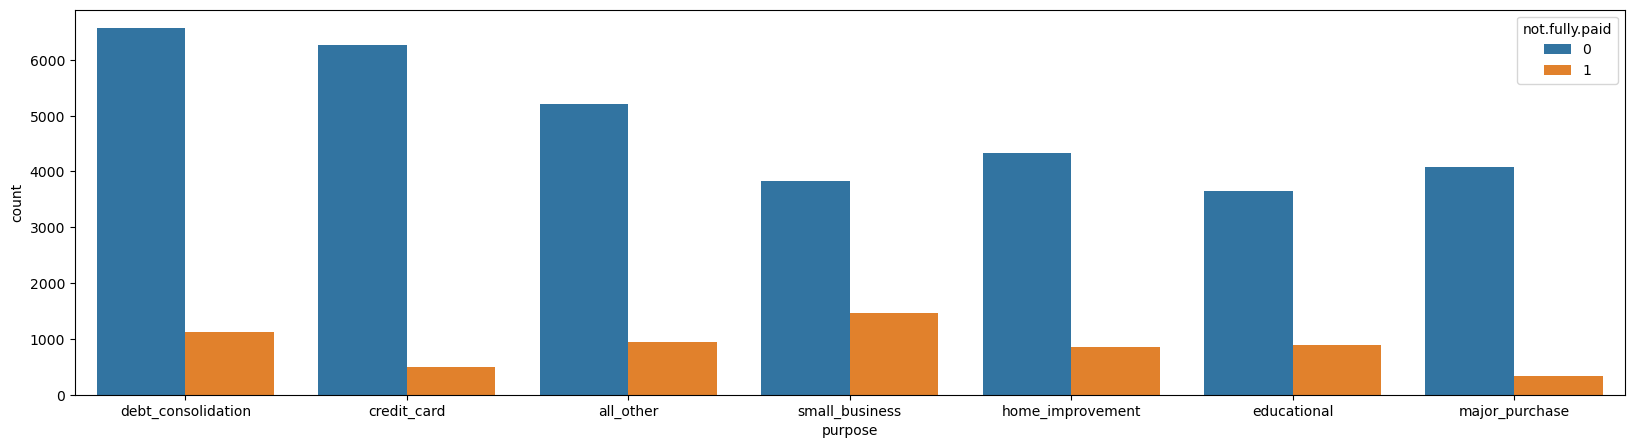

<Figure size 2000x500 with 0 Axes>

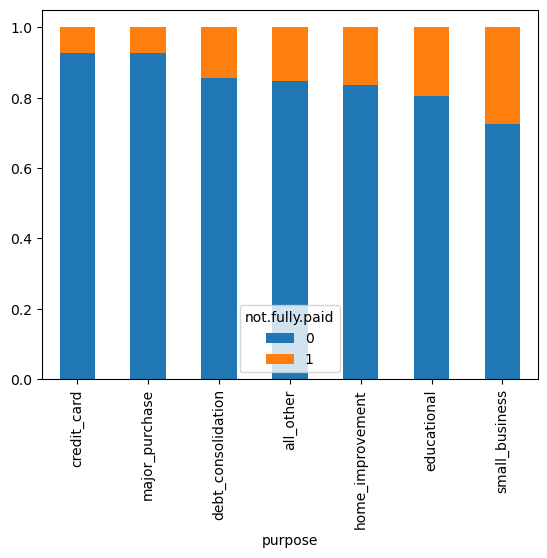

In [126]:
"""not.fully.paidごとに各目的における件数の棒グラフ"""

plt.figure(figsize=(20, 5))
sns.countplot(data=train_df, x="purpose", order=train_df["purpose"].value_counts().index, hue="not.fully.paid")
plt.show()

plt.figure(figsize=(20, 5))
tmp = train_df.copy()
tmp = pd.crosstab(train_df["purpose"], train_df["not.fully.paid"], normalize="index")
tmp = tmp.sort_values(by=0, ascending=False)
tmp.plot(kind="bar", stacked=True)

plt.show()

In [6]:
"""各目的のローンが支払われない割合"""
purpose_paid_ratio = train_df.groupby('purpose')['not.fully.paid'].mean().reset_index().rename(columns={"not.fully.paid": "not.fully.paid_1_ratio"})
display(purpose_paid_ratio)


,purpose,not.fully.paid_1_ratio
0,all_other,0.154184
1,credit_card,0.073708
2,debt_consolidation,0.144939
3,educational,0.194751
4,home_improvement,0.165412
5,major_purchase,0.073763
6,small_business,0.275758


### int.rate
ローンの利息

**知見**
- 利息が極端に高い場合は、ローンは確実に支払われる

In [7]:
train_df.describe().loc[:, "int.rate"]

count    40785.000000
mean         0.125414
std          0.030167
min          0.060800
25%          0.105300
50%          0.125200
75%          0.145100
max          0.800000
Name: int.rate, dtype: float64

<Axes: xlabel='purpose', ylabel='int.rate'>

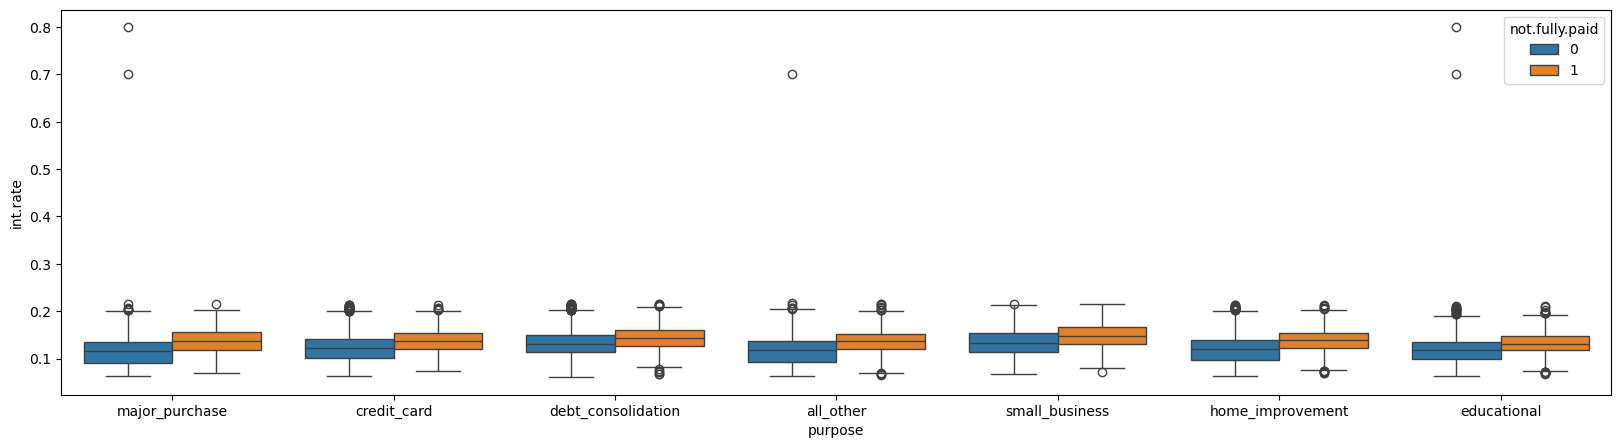

In [8]:
"""purposeごとに各目的におけるローンの利息の箱ひげ図"""
plt.figure(figsize=(20, 5))


sns.boxplot(data=train_df, y="int.rate", x="purpose", hue="not.fully.paid")

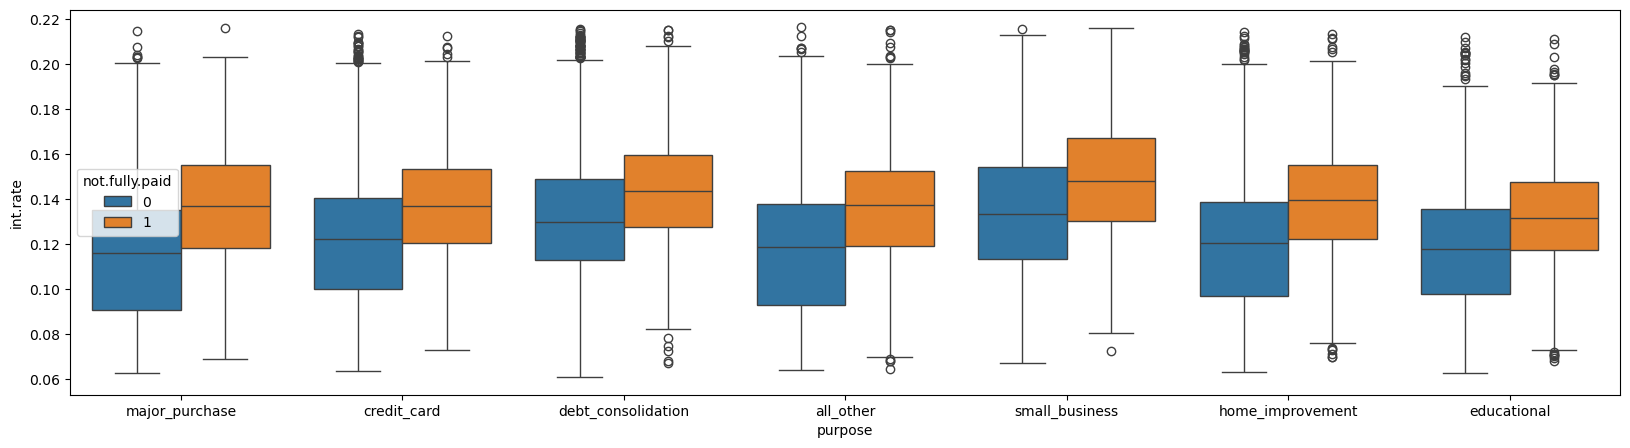

In [9]:
"""purposeごとに各目的におけるローンの利息の箱ひげ図(int.rate < 0.5)"""

# int.rateが0.5未満のデータを取得
tmp = train_df[train_df["int.rate"] < 0.5]

plt.figure(figsize=(20, 5))

sns.boxplot(data=tmp, y="int.rate", x="purpose", hue="not.fully.paid")
plt.show()

### installment
月々のローン返済額

In [10]:
train_df.describe().loc[:, "installment"]

count    40779.000000
mean       302.329408
std        208.068861
min         15.680000
25%        157.400000
50%        241.140000
75%        391.995000
max        939.380000
Name: installment, dtype: float64

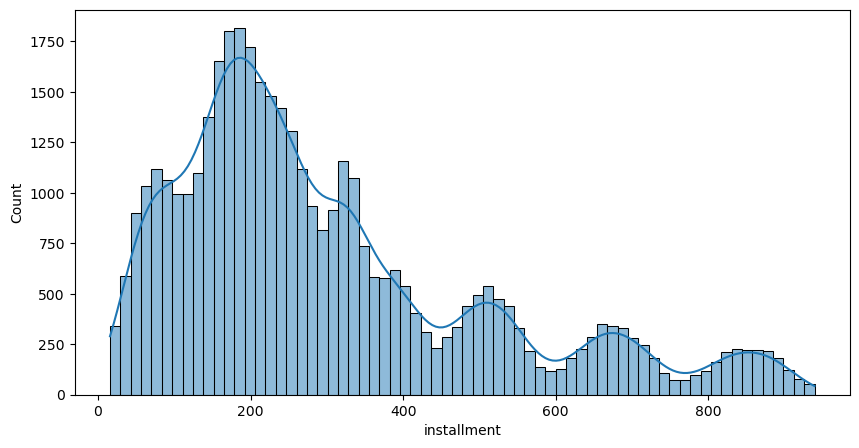

In [11]:
"""月々のローン返済額のヒストグラム"""
plt.figure(figsize=(10, 5))


sns.histplot(data=train_df, x="installment", kde=True)
plt.show()

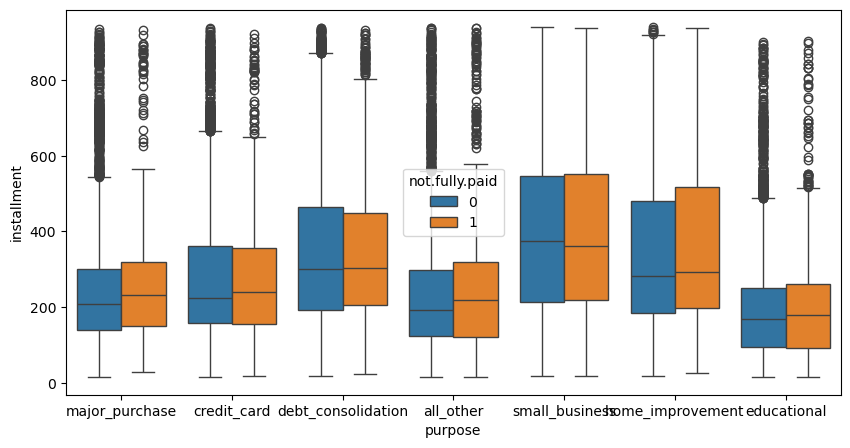

In [12]:
"""月々のローン返済額の箱ひげ図"""
plt.figure(figsize=(10, 5))


sns.boxplot(data=train_df, y="installment", x="purpose", hue="not.fully.paid")
plt.show()

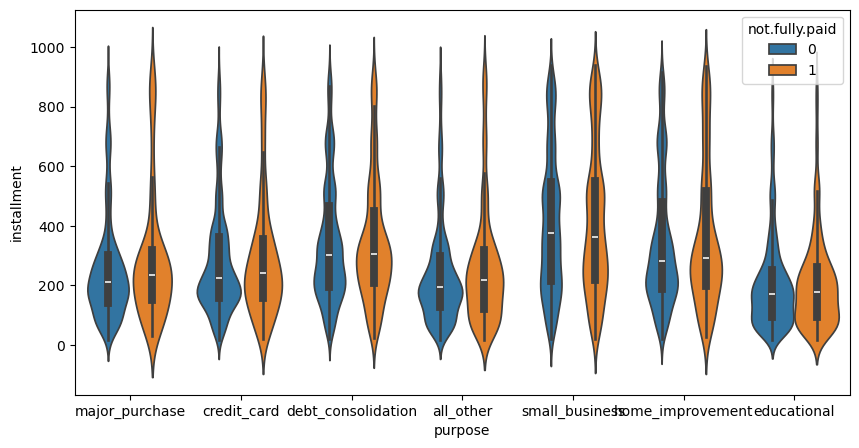

In [13]:
"""月々のローン返済額のバイオリンプロット"""
plt.figure(figsize=(10, 5))


sns.violinplot(data=train_df, y="installment", x="purpose", hue="not.fully.paid")
plt.show()

## annual.inc
年収

In [14]:
train_df.describe().loc[:, "annual.inc"]

count    4.078500e+04
mean     7.087001e+04
std      6.524275e+04
min      2.086720e+03
25%      3.868640e+04
50%      5.862029e+04
75%      8.416863e+04
max      1.913363e+06
Name: annual.inc, dtype: float64

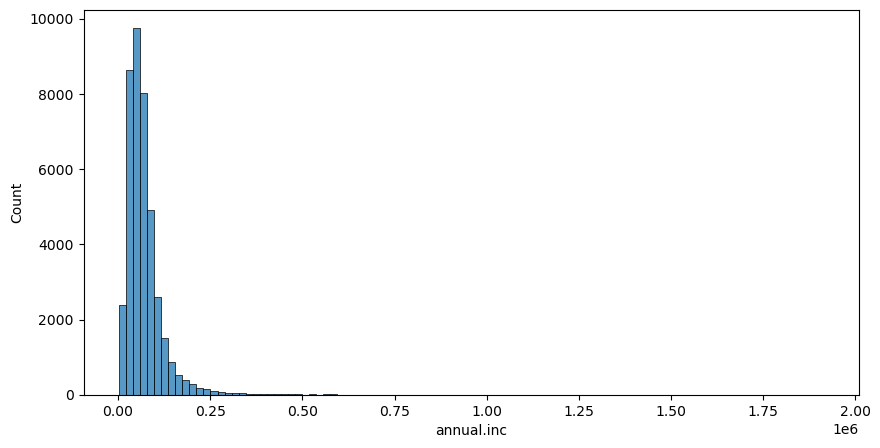

In [15]:
"""月々のローン返済額のヒストグラム（対数）"""
plt.figure(figsize=(10, 5))

tmp = train_df.copy()
tmp["log_annual.inc"] = np.log(tmp["annual.inc"])
sns.histplot(data=tmp, x="annual.inc", bins=100)
plt.show()

### dti
借入希望者の負債比率：個人の収入に対する負債の割合を示す

$$
\text{DTI}=\frac{月々の負債返済額}{月々の収入} \times 100
$$

In [16]:
train_df.describe().loc[:, "dti"]

count    40785.000000
mean        12.530579
std          6.831929
min          0.110000
25%          6.700000
50%         12.740000
75%         17.930000
max         29.930000
Name: dti, dtype: float64

<Figure size 1000x500 with 0 Axes>

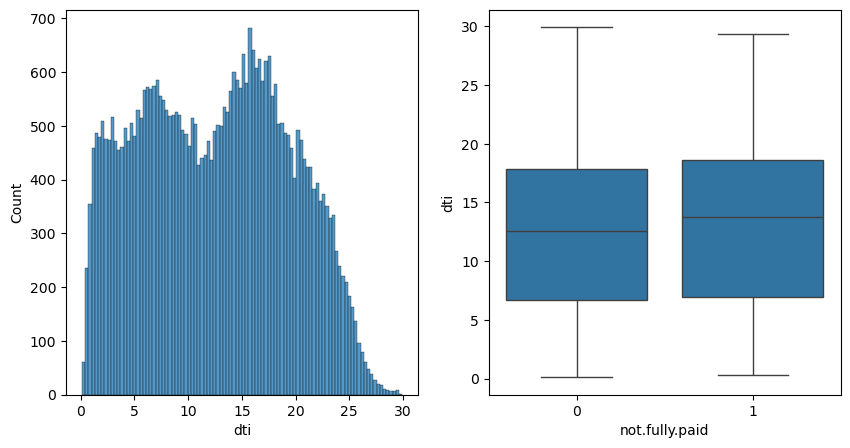

In [17]:
"""負債比率のヒストグラム（対数）"""
plt.figure(figsize=(10, 5))

fig, ax = plt.subplots(1, 2, figsize=(10,5))

sns.histplot(data=train_df, x="dti", bins=100, ax=ax[0])
sns.boxplot(data=train_df, y="dti", x="not.fully.paid",ax=ax[1])
plt.show()

### fico
借入希望者のFICOクレジットスコア：消費者の信用リスクを評価するために，広く利用されている．</br>
金融機関は，このスコアを利用して個人の信用度を評価し，ローンの承認や金利の決定に使用する

- スコア範囲:
    - FICOスコアは300から850の範囲で算出されます。スコアが高いほど信用リスクが低いことを示します。
- スコアの分類:
    - 300-579: 非常に信用リスクが高い（Poor）
    - 580-669: 信用リスクがやや高い（Fair）
    - 670-739: 平均的な信用リスク（Good）
    - 740-799: 信用リスクが低い（Very Good）
    - 800-850: 非常に信用リスクが低い（Exceptional）


In [18]:
display(train_df.describe().loc[:, "fico"])

count    40785.000000
mean       709.393061
std         39.299297
min        615.000000
25%        679.000000
50%        703.000000
75%        737.000000
max        826.000000
Name: fico, dtype: float64

<Figure size 1000x500 with 0 Axes>

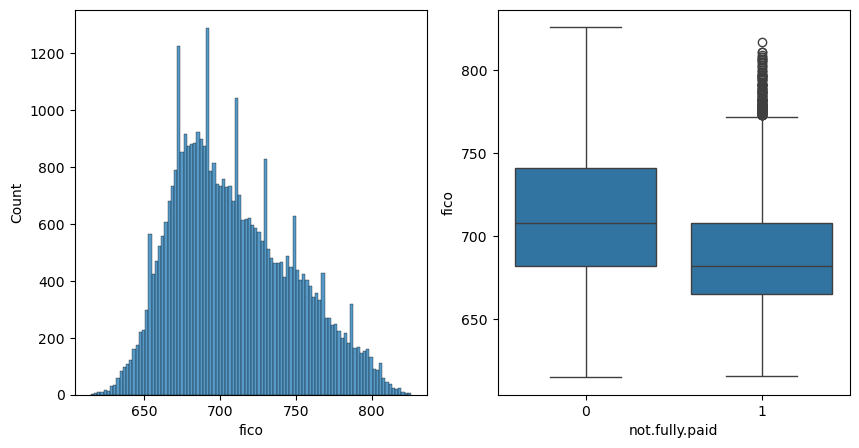

In [19]:
"""FICOスコアのヒストグラム&棒グラフ"""

plt.figure(figsize=(10, 5))

fig, ax = plt.subplots(1, 2, figsize=(10,5))

sns.histplot(data=train_df, x="fico", bins=100, ax=ax[0])
sns.boxplot(data=train_df, y="fico", x="not.fully.paid",ax=ax[1])
plt.show()

### days.with.cr.line
信頼枠開設期間（日数）</br>
クレジットカードや信用ラインが開設されてから現在までの日数を表したもの．</br>

In [138]:
train_df.describe().loc[:, "days.with.cr.line"]

count    40785.000000
mean      4736.481746
std       2568.216636
min        179.000000
25%       2965.000000
50%       4304.000000
75%       5896.000000
max      16888.000000
Name: days.with.cr.line, dtype: float64

<Figure size 1000x500 with 0 Axes>

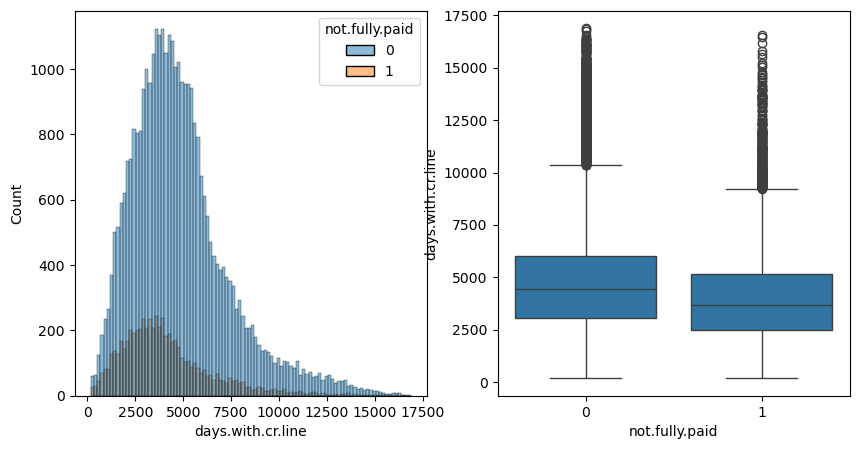

In [141]:
plt.figure(figsize=(10, 5))

fig, ax = plt.subplots(1, 2, figsize=(10,5))

sns.histplot(data=train_df, x="days.with.cr.line", bins=100, ax=ax[0], hue="not.fully.paid")
sns.boxplot(data=train_df, y="days.with.cr.line", x="not.fully.paid",ax=ax[1])
plt.show()

## revol.bal
クレジットカードの未払い残高


In [20]:
train_df.describe().loc[:, "revol.bal"]

count     40784.000000
mean      15426.217953
std       22343.735674
min           1.000000
25%        3433.000000
50%        8441.000000
75%       19085.500000
max      356328.000000
Name: revol.bal, dtype: float64

<Figure size 1000x500 with 0 Axes>

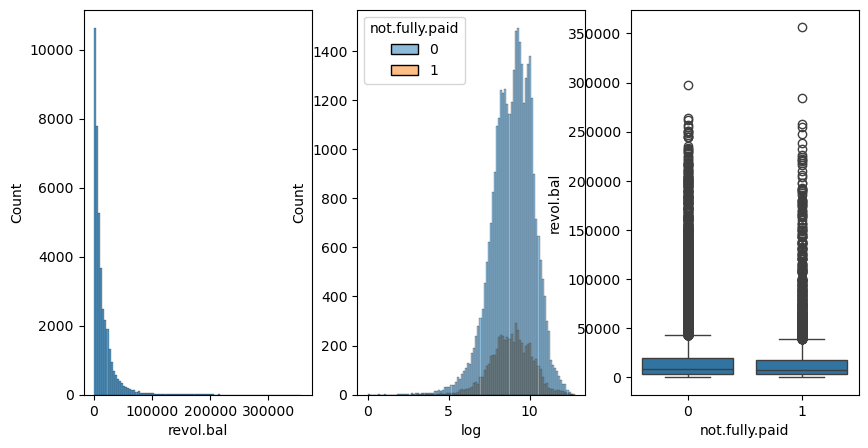

In [21]:
"""クレジットカード未のヒストグラム&棒グラフ"""

plt.figure(figsize=(10, 5))

fig, ax = plt.subplots(1, 3, figsize=(10,5))

tmp = train_df.copy()
tmp["log"] = np.log(train_df["revol.bal"])

sns.histplot(data=train_df, x="revol.bal", bins=100, ax=ax[0])
sns.histplot(data=tmp, x="log", ax=ax[1], bins=100, hue="not.fully.paid")
sns.boxplot(data=train_df, y="revol.bal", x="not.fully.paid",ax=ax[2])
plt.show()

### revol.util
クレジットカードの利用率（利用可能枠に対する使用済み金額の割合）

In [23]:
train_df.describe().loc[:, "revol.util"]

count    40773.000000
mean        46.170792
std         28.257963
min          0.100000
25%         22.600000
50%         44.500000
75%         68.900000
max        108.300000
Name: revol.util, dtype: float64

<Figure size 1000x500 with 0 Axes>

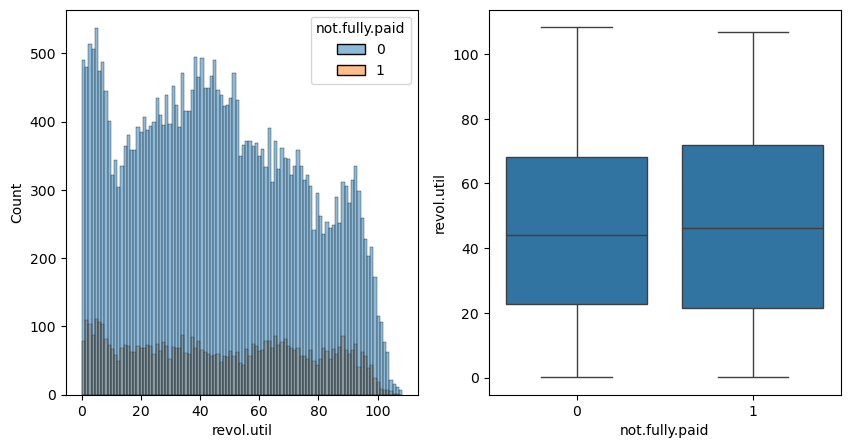

In [26]:
"""クレジットカード利用率のヒストグラム&棒グラフ"""

plt.figure(figsize=(10, 5))

fig, ax = plt.subplots(1, 2, figsize=(10,5))

sns.histplot(data=train_df, x="revol.util", bins=100, ax=ax[0], hue="not.fully.paid")
sns.boxplot(data=train_df, y="revol.util", x="not.fully.paid",ax=ax[1])
plt.show()

## inq.last.6mths
過去6ヶ月間のクレジット照会件数（利用可能枠の増額等の際に照会される件数）</br>
クレジットカードの利用可能枠の増額の申請を行った際に，</br>
金融機関やクレジットカード会社が個人のクレジット情報を紹介した回数




In [27]:
train_df.describe().loc[:, "inq.last.6mths"]

count    40785.000000
mean         1.543018
std          2.059082
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         14.000000
Name: inq.last.6mths, dtype: float64

In [81]:
train_df["inq.last.6mths"].value_counts()

0     16877
1      9214
3      4898
2      4771
4      1708
5      1248
8       824
6       757
12      206
13       79
7        78
9        76
11       45
14        3
10        1
Name: inq.last.6mths, dtype: int64

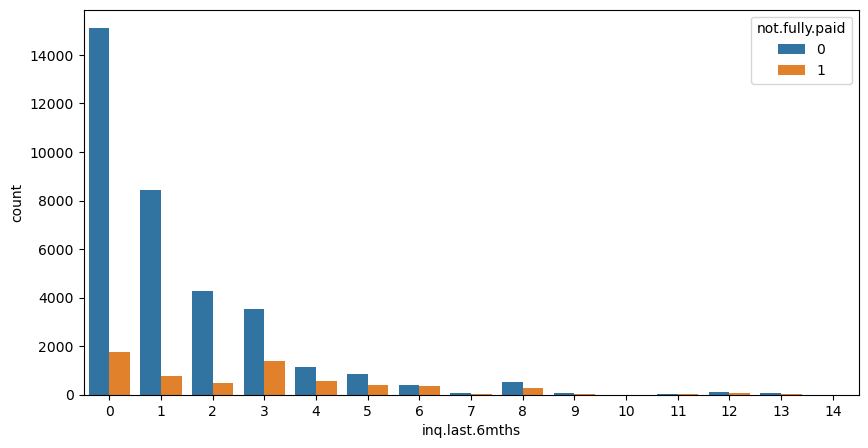

<Axes: xlabel='inq.last.6mths'>

<Figure size 1000x500 with 0 Axes>

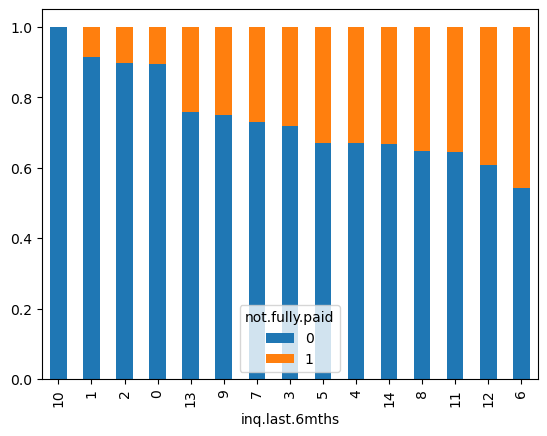

In [109]:
"""照会件数のヒストグラム&棒グラフ"""

plt.figure(figsize=(10, 5))
sns.countplot(data=train_df, x="inq.last.6mths", order=train_df["inq.last.6mths"].value_counts().sort_index().index, hue="not.fully.paid")
plt.show()

plt.figure(figsize=(10, 5))
tmp = pd.crosstab(train_df["inq.last.6mths"], train_df["not.fully.paid"], normalize="index")
tmp = tmp.sort_values(by=0, ascending=False)
tmp.plot(kind="bar", stacked=True)

### delinq.2yrs
過去２年間の延滞回数

In [110]:
train_df.describe().loc[:, "delinq.2yrs"]

count    40785.000000
mean         0.180998
std          0.513544
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: delinq.2yrs, dtype: float64

<Axes: xlabel='delinq.2yrs'>

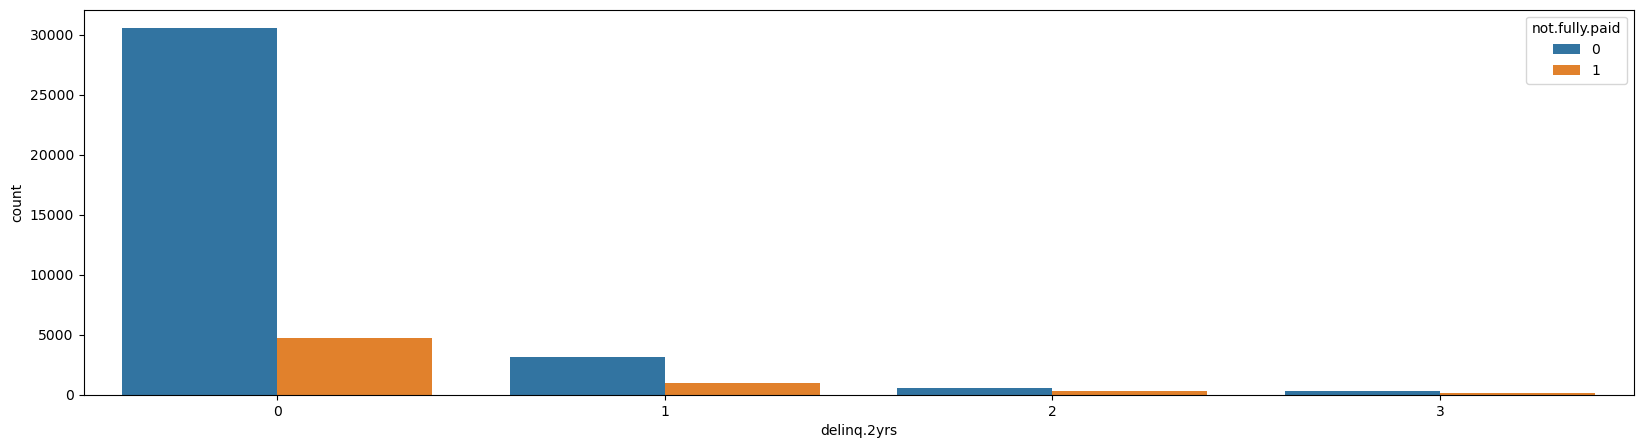

<Figure size 1000x500 with 0 Axes>

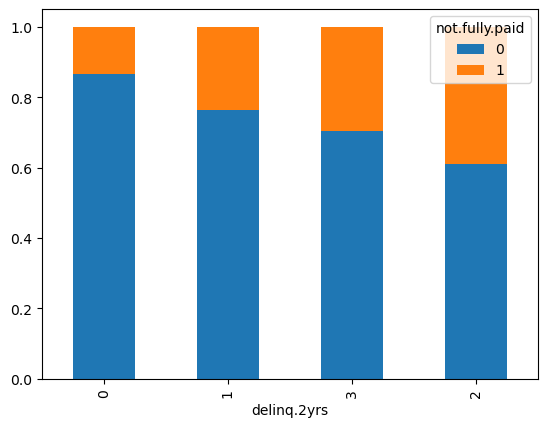

In [113]:
"""延滞回数の各回数の棒グラフ"""
plt.figure(figsize=(20, 5))
sns.countplot(data=train_df, x="delinq.2yrs", order=train_df["delinq.2yrs"].value_counts().index, hue="not.fully.paid")


plt.figure(figsize=(10, 5))
tmp = pd.crosstab(train_df["delinq.2yrs"], train_df["not.fully.paid"], normalize="index")
tmp = tmp.sort_values(by=0, ascending=False)
tmp.plot(kind="bar", stacked=True)

### pub.rec
公的記録（例：破産，税金滞納）

In [116]:
train_df.describe().loc[:, "pub.rec"]

count    40785.000000
mean         0.039696
std          0.195246
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: pub.rec, dtype: float64

<Axes: xlabel='pub.rec'>

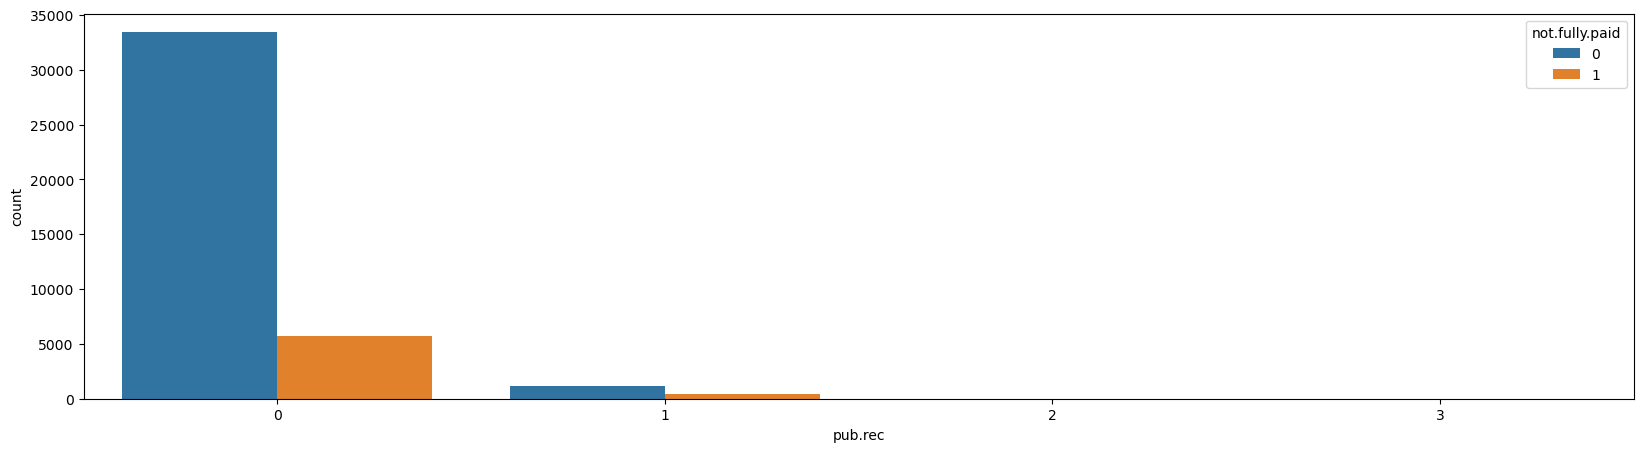

<Figure size 1000x500 with 0 Axes>

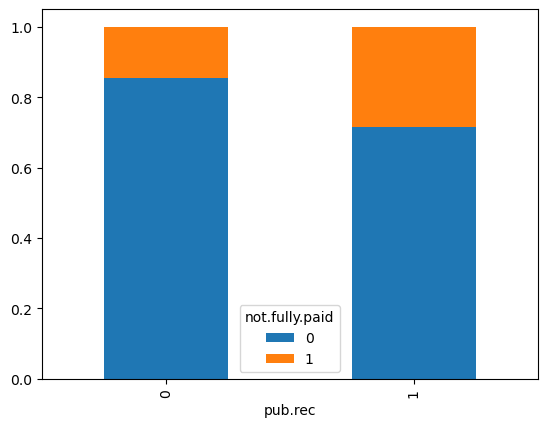

In [117]:
"""公的記録の各回数の棒グラフ"""
plt.figure(figsize=(20, 5))
sns.countplot(data=train_df, x="pub.rec", order=train_df["delinq.2yrs"].value_counts().index, hue="not.fully.paid")


plt.figure(figsize=(10, 5))
tmp = pd.crosstab(train_df["pub.rec"], train_df["not.fully.paid"], normalize="index")
tmp = tmp.sort_values(by=0, ascending=False)
tmp.plot(kind="bar", stacked=True)

## 2変数間の関係性の分析

In [120]:
numerical_df = train_df.drop("purpose", axis=1)
display(numerical_df)

,int.rate,installment,annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,0.1691,652.10,29579.74,10.66,730,3333,4955.0,39.6,4,2,0,1
1,0.1354,191.27,52808.95,13.06,707,6063,12335.0,37.8,2,1,0,0
2,0.0758,377.00,168689.22,11.98,736,2681,1505.0,5.0,1,0,0,0
3,0.1774,359.33,71325.19,20.55,702,3972,39536.0,94.1,1,0,0,0
4,0.1430,875.45,130773.88,17.61,688,5555,17295.0,56.4,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
40780,0.0981,154.87,51301.87,12.25,713,3421,5515.0,39.4,1,0,0,0
40781,0.1159,493.19,45777.85,6.34,710,2992,256.0,7.0,1,0,0,0
40782,0.1485,377.59,51056.78,22.51,666,4094,22574.0,62.4,1,0,0,0
40783,0.1422,365.85,24586.31,19.94,650,2532,832.0,5.6,0,0,0,0


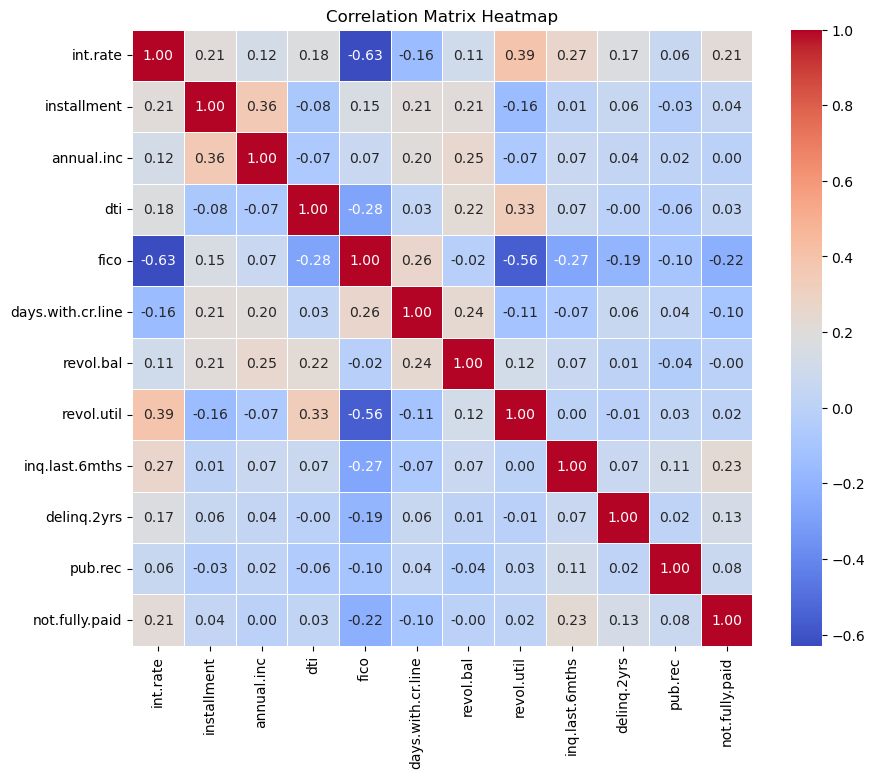

In [150]:
"""相関関係の分析"""

# ヒートマップの描画
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10})
plt.title('Correlation Matrix Heatmap')
plt.show()

### FICOスコアと金利

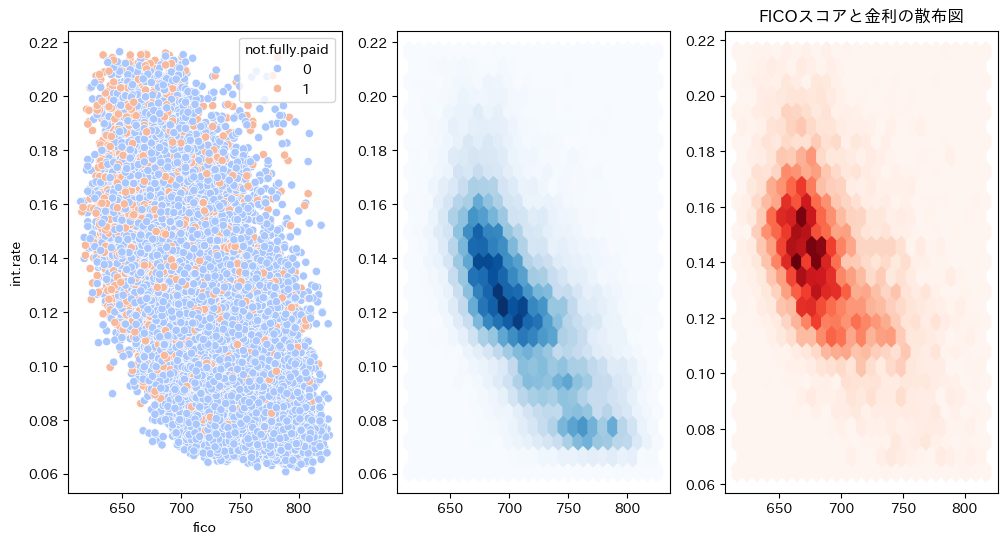

In [163]:
fig, ax =plt.subplots(1, 3 ,figsize=(12, 6))

tmp = train_df[train_df["int.rate"] < 0.5]

sns.scatterplot(data=tmp, x="fico", y="int.rate", hue="not.fully.paid", palette="coolwarm", ax=ax[0])

subset_0 = tmp[tmp["not.fully.paid"] == 0]
subset_1 = tmp[tmp["not.fully.paid"] == 1]
ax[1].hexbin(subset_0["fico"], subset_0["int.rate"], gridsize=25, cmap="Blues")
ax[2].hexbin(subset_1["fico"], subset_1["int.rate"], gridsize=25, cmap="Reds")
plt.title("FICOスコアと金利の散布図")
plt.show()

# 欠損値の補完

In [322]:
with_na_train_df = train_df.copy()
with_na_test_df = test_df.copy()

In [323]:
# purpose列のラベルエンコーディング
label_enc = LabelEncoder()
with_na_train_df.loc[with_na_train_df["purpose"].notnull(), "purpose"] = label_enc.fit_transform(with_na_train_df.loc[with_na_train_df["purpose"].notnull(), "purpose"])
with_na_test_df.loc[with_na_test_df["purpose"].notnull(), "purpose"] = label_enc.transform(with_na_test_df.loc[with_na_test_df["purpose"].notnull(), "purpose"])

#　データ型の変換
# データ型の確認と変換
with_na_train_df["purpose"] = with_na_train_df["purpose"].astype(str)
with_na_test_df["purpose"] = with_na_test_df["purpose"].astype(str)

# 欠損値は欠損値とする
with_na_train_df["purpose"].replace('nan', np.nan, inplace=True)
with_na_test_df["purpose"].replace('nan', np.nan, inplace=True)

In [324]:
"""
LightGBMで欠損値を予測
欠損値の少ない説明変数から補完し，
補完した説明変数を学習に用いる
"""
# 欠損値のない説明変数
features = ['int.rate', 'annual.inc', 'dti', 'fico', 'days.with.cr.line', 'inq.last.6mths', 'delinq.2yrs', 'pub.rec']
# 欠損値のある説明変数
missed_cols = ["revol.bal", "installment", "revol.util", "purpose"]

# 欠損値のある列に対して予測
for col in missed_cols:
    print(col)

    # 欠損値のないデータの取得
    df_notnull = with_na_train_df[with_na_train_df[col].notnull()]
    X = df_notnull[features]
    y = df_notnull[col]

    # インスタンスの作成
    if col == "purpose": # 分類
        lgbm = LGBMClassifier(random_state=42)
        scoring = 'accuracy'
        y.astype(str)
    else: # 回帰
        lgbm = LGBMRegressor(random_state=42)
        scoring = 'neg_mean_squared_error'

    params = {
    "n_estimators": [200, 300],
    "num_leaves": [10],
    "learning_rate": [0.05],
    "verbosity": [-1],
    }
    print("---学習開始---")
    grid_search = GridSearchCV(
        estimator=lgbm,
        param_grid=params,
        cv=5,
        scoring=scoring
    )

    # 最適なモデルの取得
    # モデルの訓練
    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_
    print("---学習終了---")
    print(f"最適なパラメータ: {grid_search.best_params_}")
    print("---欠損値補完開始---")
    # 訓練データセット内の欠損値の補完
    df_null_train = with_na_train_df[with_na_train_df[col].isnull()]
    X_null_train  = df_null_train[features]
    with_na_train_df.loc[with_na_train_df[col].isnull(), col] = best_model.predict(X_null_train)

    # テストデータセット内の欠損値の補完
    df_null_test = with_na_test_df[with_na_test_df[col].isnull()]
    X_null_train = df_null_test[features]
    with_na_test_df.loc[with_na_test_df[col].isnull(), col] = best_model.predict(X_null_train)

    print("---欠損値補完終了---")

    # 補完した特徴量を学習に使用
    features.append(col)

revol.bal
---学習開始---
---学習終了---
最適なパラメータ: {'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 10, 'verbosity': -1}
---欠損値補完開始---
---欠損値補完終了---
installment
---学習開始---
---学習終了---
最適なパラメータ: {'learning_rate': 0.05, 'n_estimators': 300, 'num_leaves': 10, 'verbosity': -1}
---欠損値補完開始---
---欠損値補完終了---
revol.util
---学習開始---
---学習終了---
最適なパラメータ: {'learning_rate': 0.05, 'n_estimators': 300, 'num_leaves': 10, 'verbosity': -1}
---欠損値補完開始---
---欠損値補完終了---
purpose
---学習開始---
---学習終了---
最適なパラメータ: {'learning_rate': 0.05, 'n_estimators': 200, 'num_leaves': 10, 'verbosity': -1}
---欠損値補完開始---
---欠損値補完終了---


In [330]:
# csvファイルの作成
with_na_train_df.to_csv('../data/train_imputed_with_lgbm.csv', index=True)

with_na_test_df.index = range(40785, 40785+len(with_na_test_df))
with_na_test_df.to_csv("../data/test_imputed_with_lgbm.csv", index=True)

# 新しい特徴量の作成

In [123]:
new_df = train_df.copy()

### purpose

/Users/christiantaba/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/christiantaba/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/christiantaba/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/christiantaba/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  war

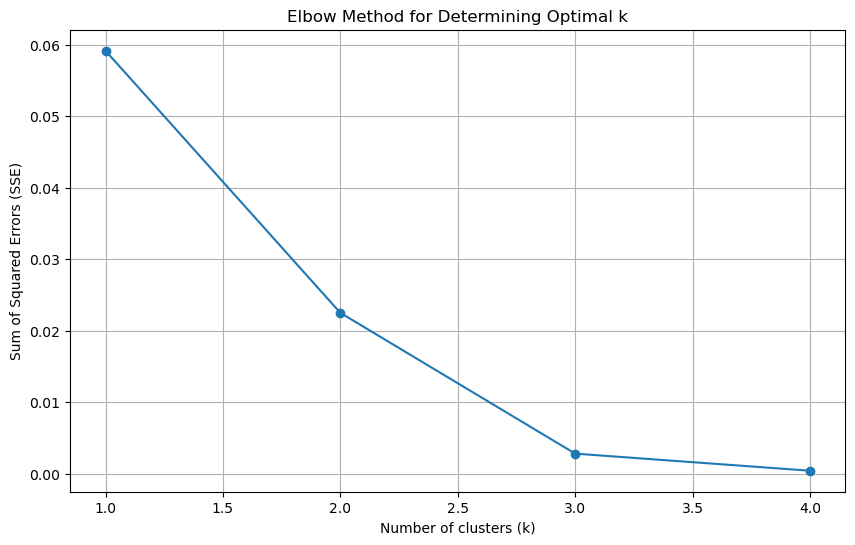

In [122]:
"""KMeansでクラスタリング"""
# クロステーブルの作成
tmp = pd.crosstab(train_df["purpose"], train_df["not.fully.paid"], normalize="index")

# エルボー法のためのSSEを計算
sse = []
k_range = range(1, 5)  # クラスタ数の範囲を設定
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tmp)
    sse.append(kmeans.inertia_)  # SSEを取得

# エルボープロットの描画
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Determining Optimal k')
plt.grid(True)
plt.show()

In [135]:
# クラスタ数
k = 3

#クロステーブルの作成
tmp = pd.crosstab(train_df["purpose"], train_df["not.fully.paid"], normalize="index")

# KMeansクラスタリングの実行
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
tmp["cluster"] = kmeans.fit_predict(tmp)

# 元のデータフレームにクラスタラベルをマッピング
cluster_mapping = tmp['cluster'].to_dict()

new_df["purpose.kmeans_3"] = new_df["purpose"].map(cluster_mapping)